Running: T(n)=T(n/3)+T(2n/3)+√n
n	T(n)	Time(ms)	Calls	Depth
--------------------------------------------------
20	27.59	0.09		0	0
40	55.48	0.05		0	0
60	90.82	0.06		0	0
80	120.1	0.12		0	0
100	168.9	0.11		0	0
120	186.5	0.12		0	0
140	238.8	0.16		0	0
160	262.3	0.17		0	0
180	290.7	0.19		0	0
200	348.4	0.21		0	0


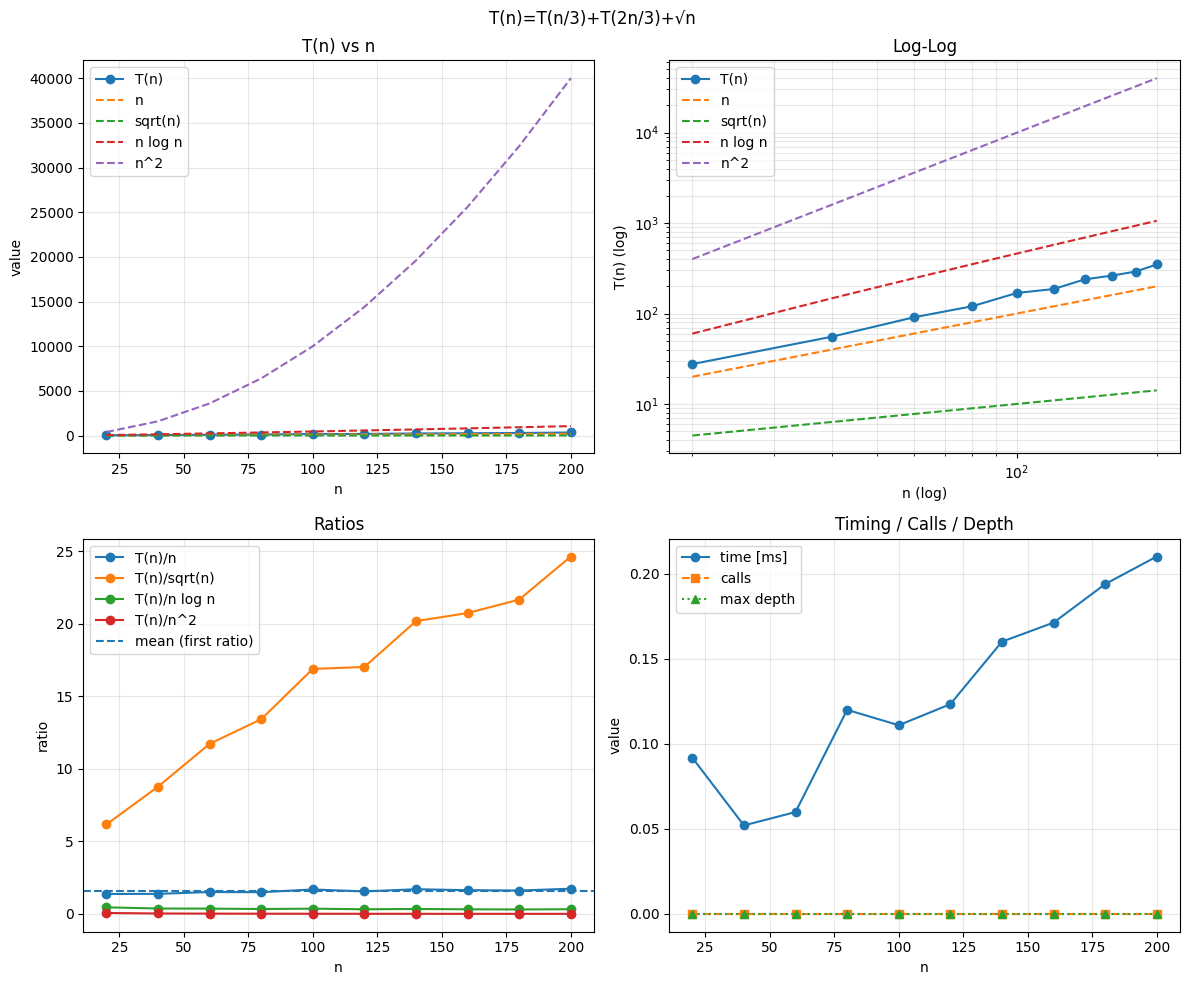

Running: T(n)=3T(n/4)+n log n
n	T(n)	Time(ms)	Calls	Depth
--------------------------------------------------
20	93.06	0.04		0	0
40	256.1	0.05		0	0
60	424.2	0.06		0	0
80	629.7	0.08		0	0
100	825.7	0.10		0	0
120	1030	0.13		0	0
140	1333	0.15		0	0
160	1580	0.17		0	0
180	1804	0.19		0	0
200	2085	0.22		0	0


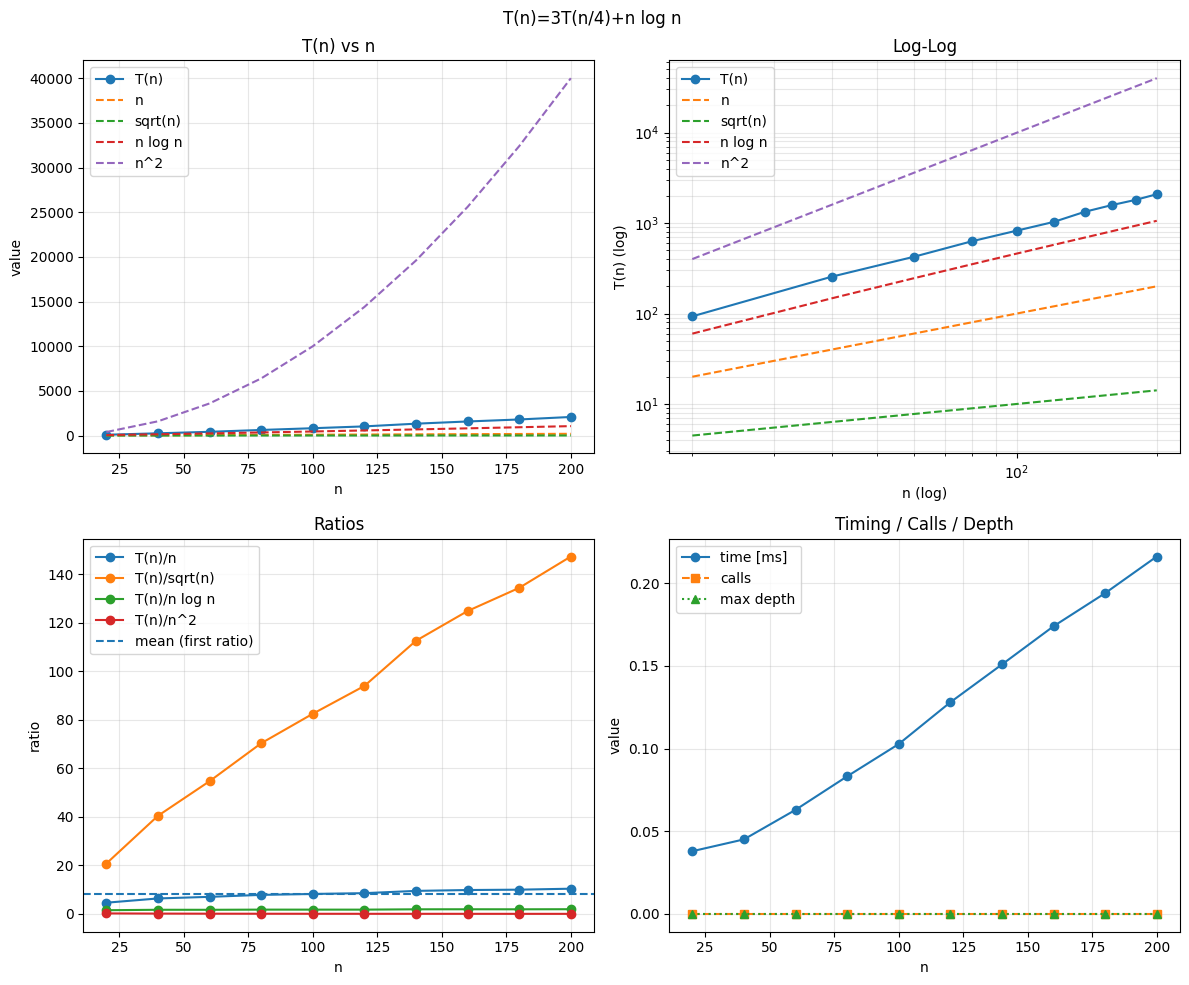

Running: T(n)=T(n-1)+n^2
n	T(n)	Time(ms)	Calls	Depth
--------------------------------------------------
20	2870	0.02		0	0
40	2.214e+04	0.03		0	0
60	7.381e+04	0.05		0	0
80	1.739e+05	0.05		0	0
100	3.384e+05	0.06		0	0
120	5.832e+05	0.07		0	0
140	9.245e+05	0.09		0	0
160	1.378e+06	0.11		0	0
180	1.96e+06	0.12		0	0
200	2.687e+06	0.12		0	0


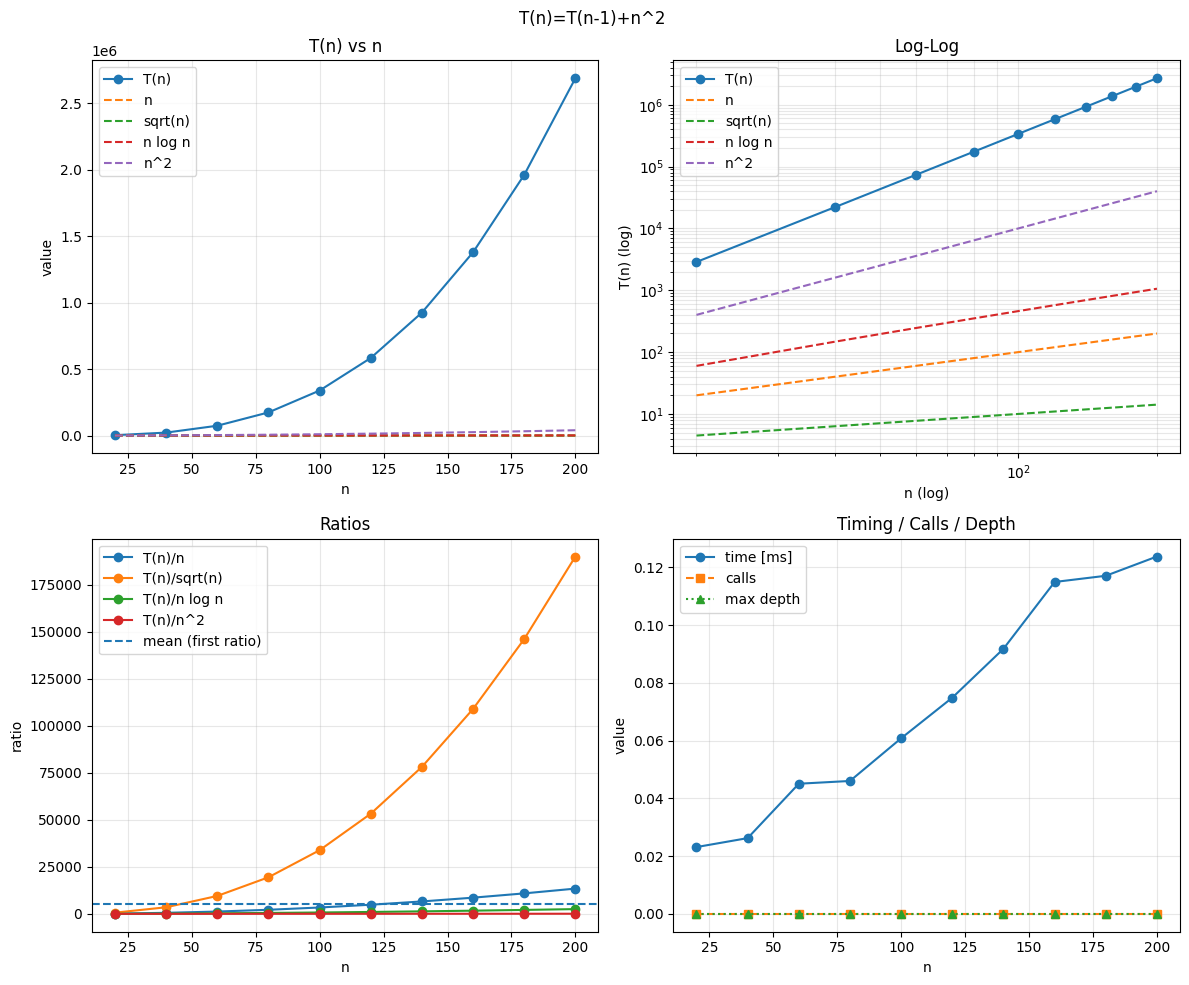

Running: T(n)=√n·T(√n)+n
n	T(n)	Time(ms)	Calls	Depth
--------------------------------------------------
20	68.43	1.48		0	0
40	130.8	0.03		0	0
60	184.2	0.04		0	0
80	237.9	0.05		0	0
100	349.6	0.06		0	0
120	393.5	0.08		0	0
140	455.9	0.10		0	0
160	519.1	0.12		0	0
180	583.3	0.13		0	0
200	648.4	0.15		0	0


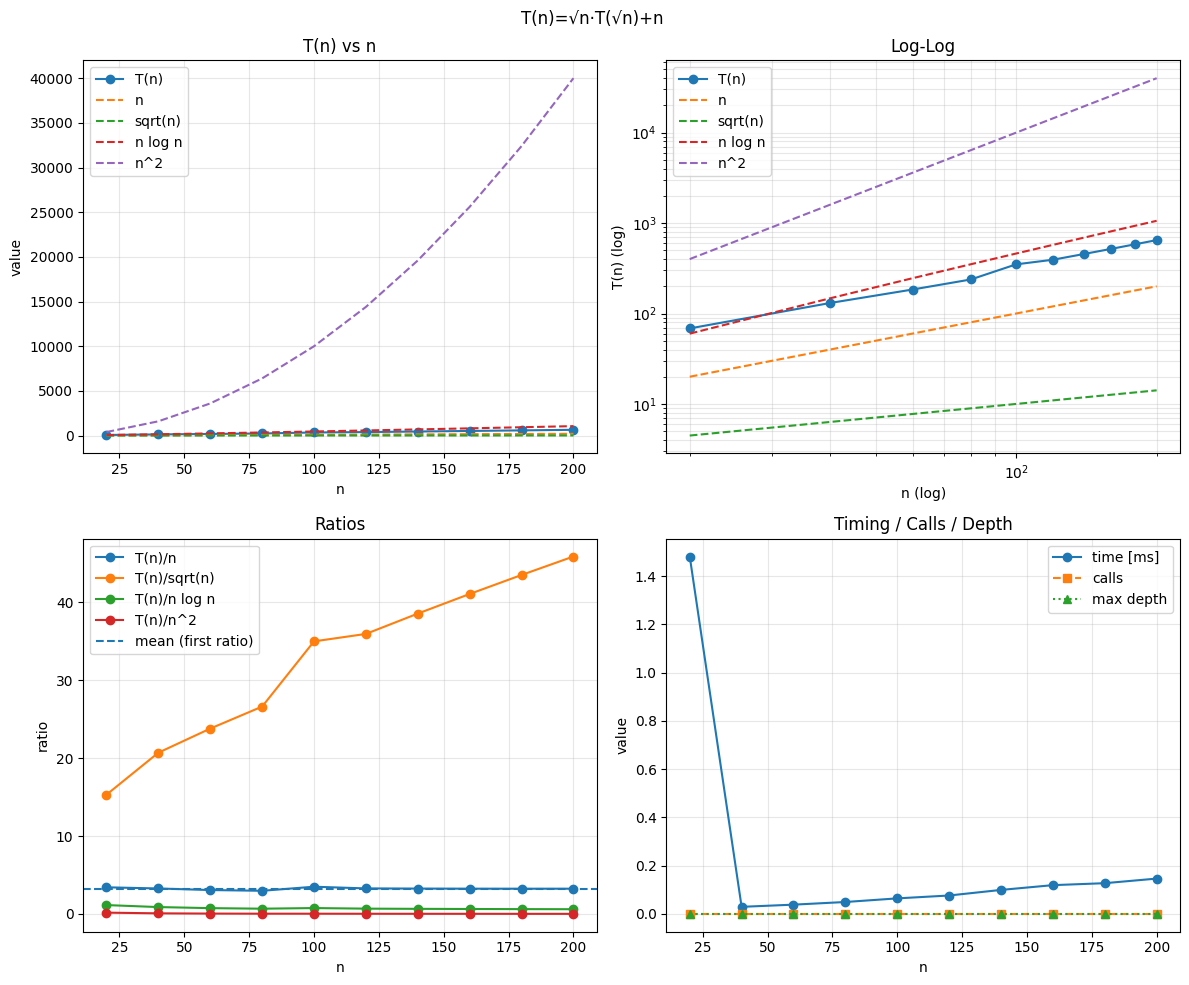

Running: T(n)=T(n/3)+T(n/6)+T(n/2)+n
n	T(n)	Time(ms)	Calls	Depth
--------------------------------------------------
20	65	0.03		0	0
40	154	0.04		0	0
60	252	0.06		0	0
80	354	0.08		0	0
100	443	0.12		0	0
120	591	0.12		0	0
140	658	0.16		0	0
160	797	0.17		0	0
180	933	0.19		0	0
200	1022	0.22		0	0


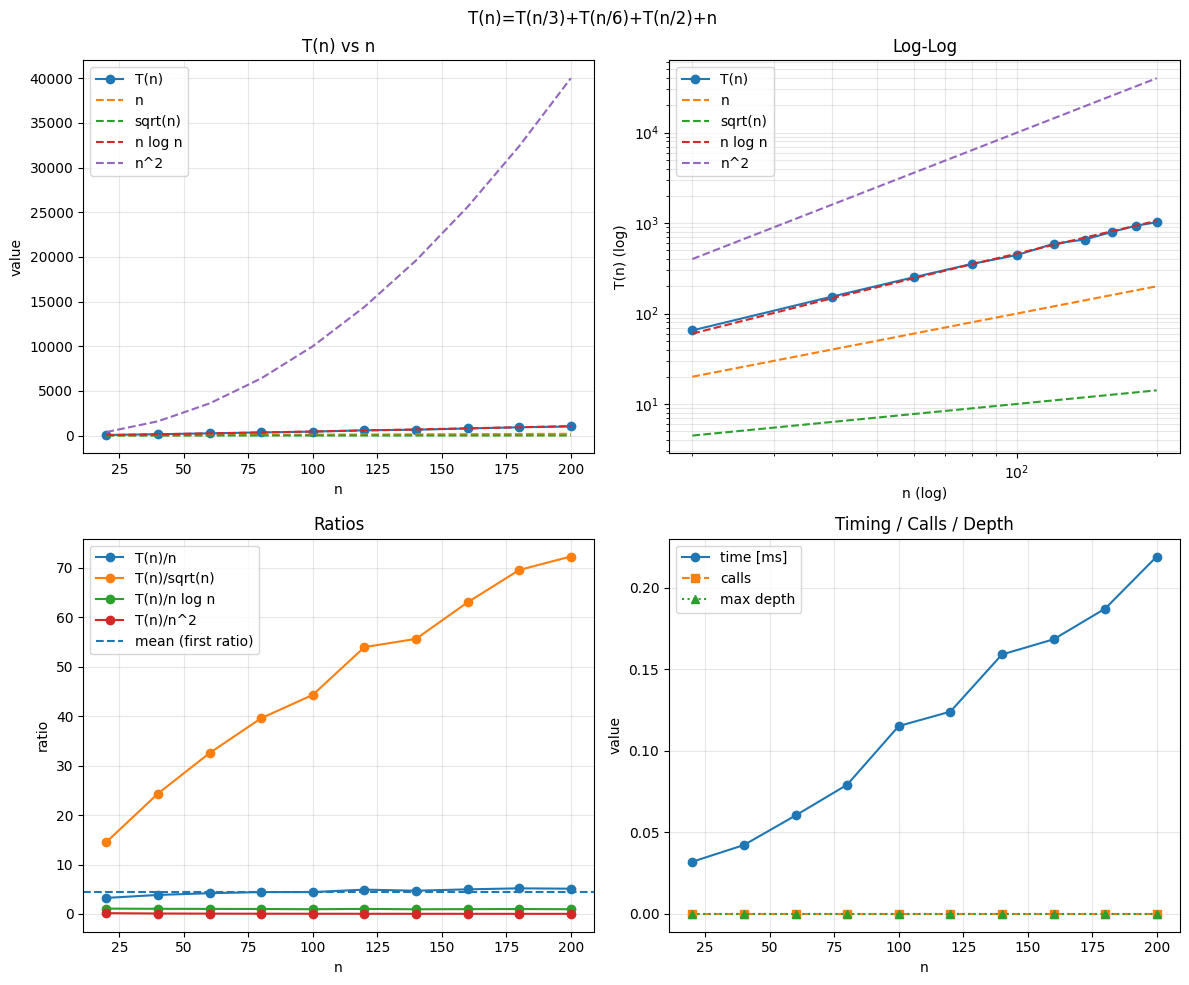

Running: T(n)=4T(n/2)+n^2 log n
n	T(n)	Time(ms)	Calls	Depth
--------------------------------------------------
20	3197	0.05		0	0
40	1.869e+04	0.06		0	0
60	4.639e+04	0.08		0	0
80	1.028e+05	0.10		0	0
100	1.71e+05	0.12		0	0
120	2.545e+05	0.17		0	0
140	3.867e+05	0.18		0	0
160	5.411e+05	0.21		0	0
180	6.763e+05	0.25		0	0
200	8.959e+05	0.29		0	0


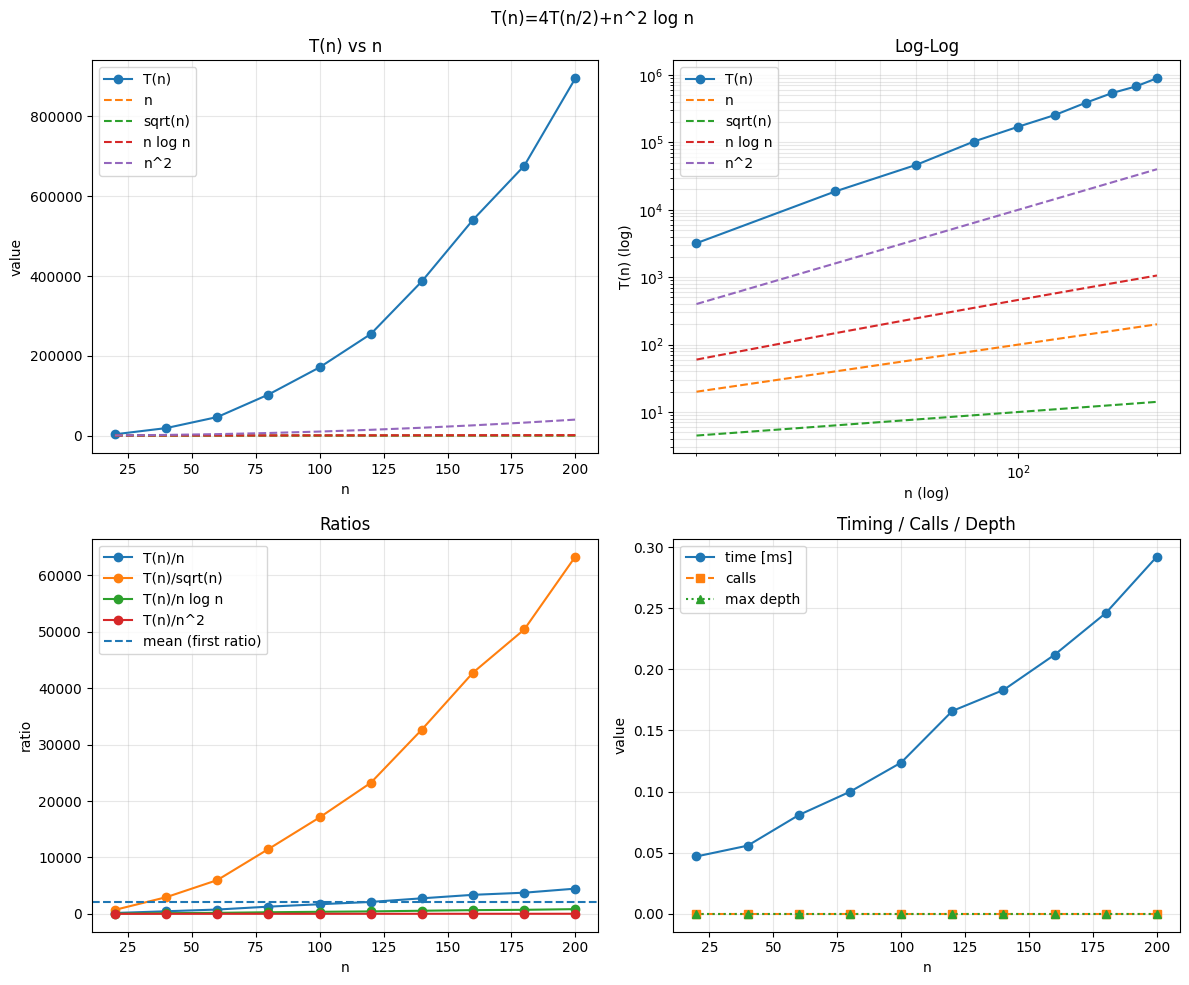

Running: T(n)=9T(n/3)+n^2
n	T(n)	Time(ms)	Calls	Depth
--------------------------------------------------
20	1777	0.06		0	0
40	5146	0.09		0	0
60	1.959e+04	0.14		0	0
80	2.714e+04	0.17		0	0
100	4.272e+04	0.22		0	0
120	6.071e+04	0.27		0	0
140	8.166e+04	0.33		0	0
160	9.908e+04	0.36		0	0
180	2.087e+05	0.41		0	0
200	2.394e+05	0.46		0	0


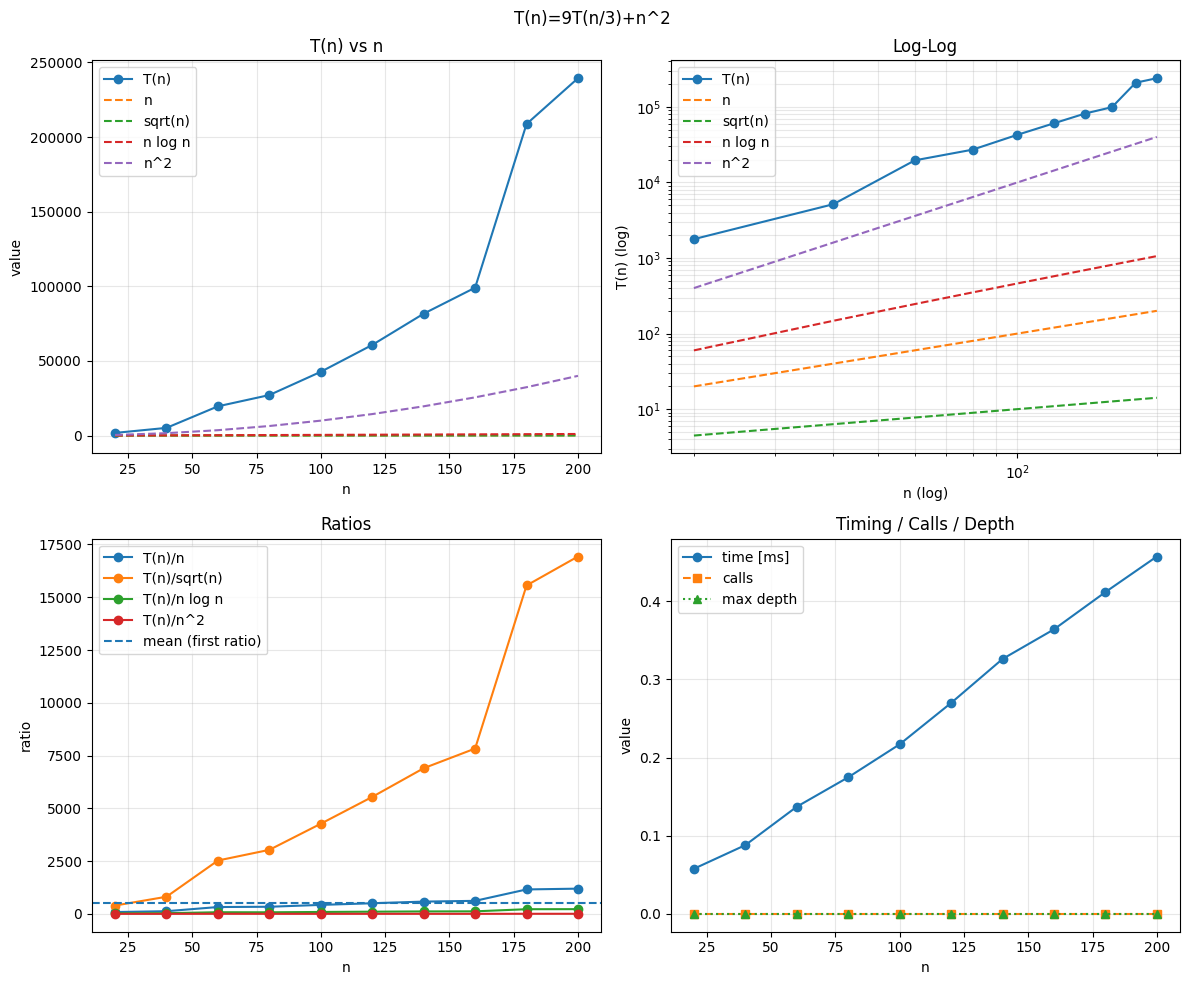

In [10]:
import time
import math
import numpy as np
from functools import lru_cache
import matplotlib.pyplot as plt

# ============================================================
# Generic Recurrence Specification
# ============================================================

class RecurrenceSpec:
    """
    A generic recurrence is defined by:
      - subproblems(n) -> list of (size, weight) pairs
          meaning: T(n) = sum_i weight_i * T(size_i) + f(n)
      - f(n): additive non-recursive cost term (callable: int -> float)
      - base(n): returns a finite value for base cases, or None to continue
      - guard(n): sanitize/clip n before use (e.g., ensure >= 0 or >= 1)
      - name: label used in logs/plots
    """
    def __init__(self, subproblems, f, base, guard=None, name="Recurrence"):
        self.subproblems = subproblems          # callable: n -> list[(int, float)]
        self.f = f                               # callable: n -> float
        self.base = base                         # callable: n -> Optional[float]
        self.guard = (lambda n: max(0, int(n))) if guard is None else guard
        self.name = name

    # Convenience: Master-form builder for a,b,f with standard flooring
    @staticmethod
    def master(a, b, f, base_n=1, base_val=1.0, name=None):
        assert a >= 0 and b >= 1
        def subproblems(n):
            sz = n // b
            return [(sz, 1.0)] * a
        def base(n):
            return base_val if n <= base_n else None
        nm = name or f"Master a={a}, b={b}"
        return RecurrenceSpec(subproblems=subproblems, f=f, base=base, name=nm)

# ============================================================
# Experiment Engine (generic)
# ============================================================

class RecurrenceExperiment:
    def __init__(self, spec: RecurrenceSpec):
        self.spec = spec
        self.reset_counters()

    def reset_counters(self):
        self.call_count = 0
        self.max_depth = 0

    def _sanitize_children(self, children):
        """Ensure subproblem sizes and weights are valid integers / floats."""
        out = []
        for (sz, w) in children:
            sz = int(sz)
            if sz < 0:
                sz = 0
            out.append((sz, float(w)))
        return out

    @lru_cache(maxsize=None)
    def T_recursive(self, n, depth=0):
        n = self.spec.guard(int(n))
        self.call_count += 1
        self.max_depth = max(self.max_depth, depth)

        # Base?
        b = self.spec.base(n)
        if b is not None:
            return float(b)

        # Children
        children = self._sanitize_children(self.spec.subproblems(n))

        # If any child is equal to n, protect from infinite recursion by forcing progress.
        # Common patterns (e.g., n -> floor(n/2)) already progress, but we guard anyway.
        safe_children = []
        for (sz, w) in children:
            if sz >= n and n > 0:
                sz = n - 1
            safe_children.append((sz, w))

        # Sum weighted subcalls + additive cost
        total = 0.0
        for (sz, w) in safe_children:
            total += w * self.T_recursive(sz, depth + 1)
        total += float(self.spec.f(n))
        return total

    def T_iterative(self, n_max: int):
        """
        Bottom-up dynamic evaluation for integer n in [0..n_max].
        Works for recurrences whose subproblem sizes are <= current n.
        (Will automatically fall back to recursive for out-of-range children.)
        """
        n_max = int(n_max)
        T = np.zeros(n_max + 1, dtype=float)

        for n in range(n_max + 1):
            n_guard = self.spec.guard(n)
            b = self.spec.base(n_guard)
            if b is not None:
                T[n] = float(b)
                continue

            children = self._sanitize_children(self.spec.subproblems(n_guard))
            total = float(self.spec.f(n_guard))
            ok_bottom_up = True

            for (sz, w) in children:
                if sz < 0:
                    sz = 0
                if sz <= n_guard and sz <= n_max:
                    total += w * T[sz]
                else:
                    ok_bottom_up = False
                    break

            if ok_bottom_up:
                T[n] = total
            else:
                # For “forward” dependencies (e.g., T(n)=T(n-1)+...), we can still do bottom-up.
                # But for non-monotone or out-of-range, we fallback to memoized recursion.
                T[n] = self.T_recursive(n_guard)

        return T

    # ------------------- Utilities for analysis & plotting -------------------

    @staticmethod
    def complexity_fn(kind: str, **kw):
        """
        Factory for common comparison functions.
          kind in {"n", "nlogn", "n^a", "sqrt", "log", "a^n", "n^a log^k n"}
        """
        if kind == "n":
            return lambda n: float(n)
        if kind == "sqrt":
            return lambda n: float(math.sqrt(n))
        if kind == "log":
            return lambda n: float(math.log(n)) if n > 1 else 0.0
        if kind == "nlogn":
            return lambda n: float(n * (math.log(n) if n > 1 else 0.0))
        if kind == "n^a":
            a = kw.get("a", 2.0)
            return lambda n: float(n ** a)
        if kind == "a^n":
            a = kw.get("a", 2.0)
            return lambda n: float(a ** n)
        if kind == "n^a log^k n":
            a = kw.get("a", 1.0)
            k = kw.get("k", 1.0)
            return lambda n: float((n ** a) * ((math.log(n) if n > 1 else 0.0) ** k))
        raise ValueError(f"Unknown complexity kind: {kind}")

    def run_timing_experiment(self, n_values, use_iterative=True):
        times_ms, values = [], []
        calls, depths = [], []

        print(f"Running: {self.spec.name}")
        print("n\tT(n)\tTime(ms)\tCalls\tDepth")
        print("-" * 50)

        for n in n_values:
            self.reset_counters()
            start = time.time()
            if use_iterative:
                T = self.T_iterative(n)   # compute up to n
                val = float(T[n])
            else:
                val = float(self.T_recursive(n))
            dt = (time.time() - start) * 1000.0

            times_ms.append(dt)
            values.append(val)
            calls.append(self.call_count)
            depths.append(self.max_depth)

            print(f"{n}\t{val:.4g}\t{dt:.2f}\t\t{self.call_count}\t{self.max_depth}")

        return np.array(n_values), np.array(values), np.array(times_ms), np.array(calls), np.array(depths)

    def growth_ratios(self, n_values, values, comparators):
        """
        comparators: dict[str, callable(n)->float]
        Returns dict mapping name -> ratio array (T(n)/g(n) with g(n)>0 else nan)
        """
        out = {}
        for name, g in comparators.items():
            ratios = []
            for n, v in zip(n_values, values):
                denom = g(n)
                ratios.append(v / denom if denom > 0 else np.nan)
            out[name] = np.array(ratios, dtype=float)
        return out

    # -------- Plot helpers (each in its own figure; no seaborn, no explicit colors) --------

    def plot_T_vs_n(self, n_values, values, comparators=None, title_suffix=""):
        plt.figure()
        plt.plot(n_values, values, marker="o", label="T(n)")
        if comparators:
            for name, g in comparators.items():
                plt.plot(n_values, [g(n) for n in n_values], linestyle="--", label=name)
        plt.xlabel("n"); plt.ylabel("value")
        plt.title(f"{self.spec.name} — T(n) vs n {title_suffix}")
        plt.grid(True, alpha=0.3); plt.legend(); plt.tight_layout()

    def plot_loglog(self, n_values, values, comparators=None, title_suffix=""):
        plt.figure()
        plt.loglog(n_values, values, marker="o", label="T(n)")
        if comparators:
            for name, g in comparators.items():
                plt.loglog(n_values, [max(g(n), 1e-12) for n in n_values], linestyle="--", label=name)
        plt.xlabel("n (log)"); plt.ylabel("T(n) (log)")
        plt.title(f"{self.spec.name} — Log-Log {title_suffix}")
        plt.grid(True, which="both", alpha=0.3); plt.legend(); plt.tight_layout()

    def plot_ratio(self, n_values, ratio, label="T(n)/g(n)", title_suffix=""):
        plt.figure()
        plt.plot(n_values, ratio, marker="o")
        if np.isfinite(ratio).any():
            mean = np.nanmean(ratio)
            plt.axhline(y=mean, linestyle="--", label=f"mean={mean:.3g}")
        plt.xlabel("n"); plt.ylabel(label)
        plt.title(f"{self.spec.name} — {label} {title_suffix}")
        plt.grid(True, alpha=0.3); plt.legend(); plt.tight_layout()

    def plot_dashboard_2x2(self, n_values, values, times_ms,
                        comparators=None, calls=None, depths=None, title_suffix=""):
        fig, axes = plt.subplots(2, 2, figsize=(12, 10))
        ax1, ax2, ax3, ax4 = axes.ravel()

        # --- (1) T(n) vs n with optional comparators ---
        ax1.plot(n_values, values, marker="o", label="T(n)")
        if comparators:
            for name, g in comparators.items():
                ax1.plot(n_values, [g(n) for n in n_values], linestyle="--", label=name)
        ax1.set_xlabel("n"); ax1.set_ylabel("value")
        ax1.set_title("T(n) vs n")
        ax1.grid(True, alpha=0.3); ax1.legend()

        # --- (2) Log-log comparison ---
        ax2.loglog(n_values, values, marker="o", label="T(n)")
        if comparators:
            for name, g in comparators.items():
                ax2.loglog(n_values, [max(g(n), 1e-12) for n in n_values], linestyle="--", label=name)
        ax2.set_xlabel("n (log)"); ax2.set_ylabel("T(n) (log)")
        ax2.set_title("Log-Log")
        ax2.grid(True, which="both", alpha=0.3); ax2.legend()

        # --- (3) Ratios T(n)/g(n) for all comparators (or default T(n)/n) ---
        if comparators:
            for name, g in comparators.items():
                ratio = [values[i] / (g(n) if g(n) > 0 else np.nan) for i, n in enumerate(n_values)]
                ax3.plot(n_values, ratio, marker="o", label=f"T(n)/{name}")
            # horizontal mean for first ratio just as a visual cue
            first_name = next(iter(comparators))
            first_ratio = [values[i] / (comparators[first_name](n) if comparators[first_name](n) > 0 else np.nan)
                        for i, n in enumerate(n_values)]
            if np.isfinite(first_ratio).any():
                ax3.axhline(np.nanmean(first_ratio), linestyle="--", label="mean (first ratio)")
            ax3.set_ylabel("ratio")
        else:
            ratio = [values[i] / n if n > 0 else np.nan for i, n in enumerate(n_values)]
            ax3.plot(n_values, ratio, marker="o", label="T(n)/n")
            if np.isfinite(ratio).any():
                ax3.axhline(np.nanmean(ratio), linestyle="--", label="mean")
            ax3.set_ylabel("T(n)/n")
        ax3.set_xlabel("n")
        ax3.set_title("Ratios")
        ax3.grid(True, alpha=0.3); ax3.legend()

        # --- (4) Timing (and optionally calls/depths) ---
        ax4.plot(n_values, times_ms, marker="o", label="time [ms]")
        if calls is not None:
            ax4.plot(n_values, calls, linestyle="--", marker="s", label="calls")
        if depths is not None:
            ax4.plot(n_values, depths, linestyle=":", marker="^", label="max depth")
        ax4.set_xlabel("n"); ax4.set_ylabel("value")
        ax4.set_title("Timing / Calls / Depth")
        ax4.grid(True, alpha=0.3); ax4.legend()

        fig.suptitle(f"{self.spec.name} {title_suffix}")
        plt.tight_layout()
        return fig


# ============================================================
# Ready-to-use examples matching your cases
# ============================================================

def make_examples():
    examples = []

    # 1) Your original: T(n) = T(n/3) + T(2n/3) + sqrt(n)
    def sub_1(n): return [(n // 3, 1.0), ((2 * n) // 3, 1.0)]
    def f_1(n): return math.sqrt(n)
    def base_1(n): return 1.0 if n <= 3 else None
    examples.append(RecurrenceSpec(sub_1, f_1, base_1, name="T(n)=T(n/3)+T(2n/3)+√n"))

    # 2) 3T(n/4) + n log n
    def f_2(n): return n * (math.log(n) if n > 1 else 0.0)
    ex2 = RecurrenceSpec.master(a=3, b=4, f=f_2, base_n=1, base_val=1.0,
                                name="T(n)=3T(n/4)+n log n")
    examples.append(ex2)

    # 3) T(n) = T(n-1) + n^2
    def sub_3(n): return [(n - 1, 1.0)]
    def f_3(n): return float(n ** 2)
    def base_3(n): return 0.0 if n <= 0 else None
    examples.append(RecurrenceSpec(sub_3, f_3, base_3, name="T(n)=T(n-1)+n^2"))

    # 4) T(n) = sqrt(n) * T(sqrt(n)) + n
    #    (weight on the recursive call is sqrt(n))
    def sub_4(n): return [(int(math.isqrt(max(n, 0))), math.sqrt(n))]
    def f_4(n): return float(n)
    def base_4(n): return 1.0 if n <= 1 else None
    examples.append(RecurrenceSpec(sub_4, f_4, base_4, name="T(n)=√n·T(√n)+n"))

    # 5) Exotic: T(n) = T(n/3) + T(n/6) + T(n/2) + n
    def sub_5(n): return [(n // 3, 1.0), (n // 6, 1.0), (n // 2, 1.0)]
    def f_5(n): return float(n)
    def base_5(n): return 1.0 if n <= 2 else None
    examples.append(RecurrenceSpec(sub_5, f_5, base_5, name="T(n)=T(n/3)+T(n/6)+T(n/2)+n"))

    # 6) Advanced FFT variant facade: T(n) = 4T(n/2) + n^2 log n
    def f_6(n): return (n ** 2) * (math.log(n) if n > 1 else 0.0)
    ex6 = RecurrenceSpec.master(a=4, b=2, f=f_6, base_n=1, base_val=1.0,
                                name="T(n)=4T(n/2)+n^2 log n")
    examples.append(ex6)

    # 7) 9T(n/3) + n^2
    ex7 = RecurrenceSpec.master(a=9, b=3, f=lambda n: float(n ** 2), base_n=1, base_val=1.0,
                                name="T(n)=9T(n/3)+n^2")
    examples.append(ex7)

    return examples

# ============================================================
# Example usage
# ============================================================

if __name__ == "__main__":
    # Pick any spec
    # Build experiment as before
    specs = make_examples()
    for spec in specs:
        exp = RecurrenceExperiment(spec)

        n_values = list(range(20, 201, 20))

        # now returns calls & depths too
        n_arr, Tn, times_ms, calls, depths = exp.run_timing_experiment(n_values, use_iterative=True)

        comparators = {
            "n": exp.complexity_fn("n"),
            "sqrt(n)": exp.complexity_fn("sqrt"),
            "n log n": exp.complexity_fn("nlogn"),
            "n^2": exp.complexity_fn("n^a", a=2.0),
        }

        # single 2x2 figure
        exp.plot_dashboard_2x2(n_arr, Tn, times_ms, comparators=comparators, calls=calls, depths=depths)
        plt.show()


In [3]:
spec = RecurrenceSpec.master(
    a=3, b=4,
    f=lambda n: n * (math.log(n) if n > 1 else 0.0),
    base_n=1, base_val=1.0,
    name="My Master Recurrence"
)
